In [972]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input, Dropout
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 1 day, 10:00:17 ago. (Use '!kill 17008' to kill it.)

In [939]:
df = pd.read_csv('diabetes.csv')

In [940]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [941]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


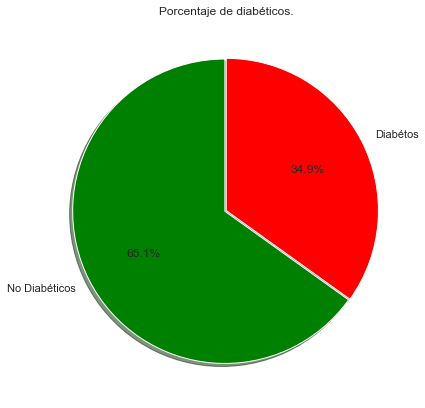

In [942]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [943]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

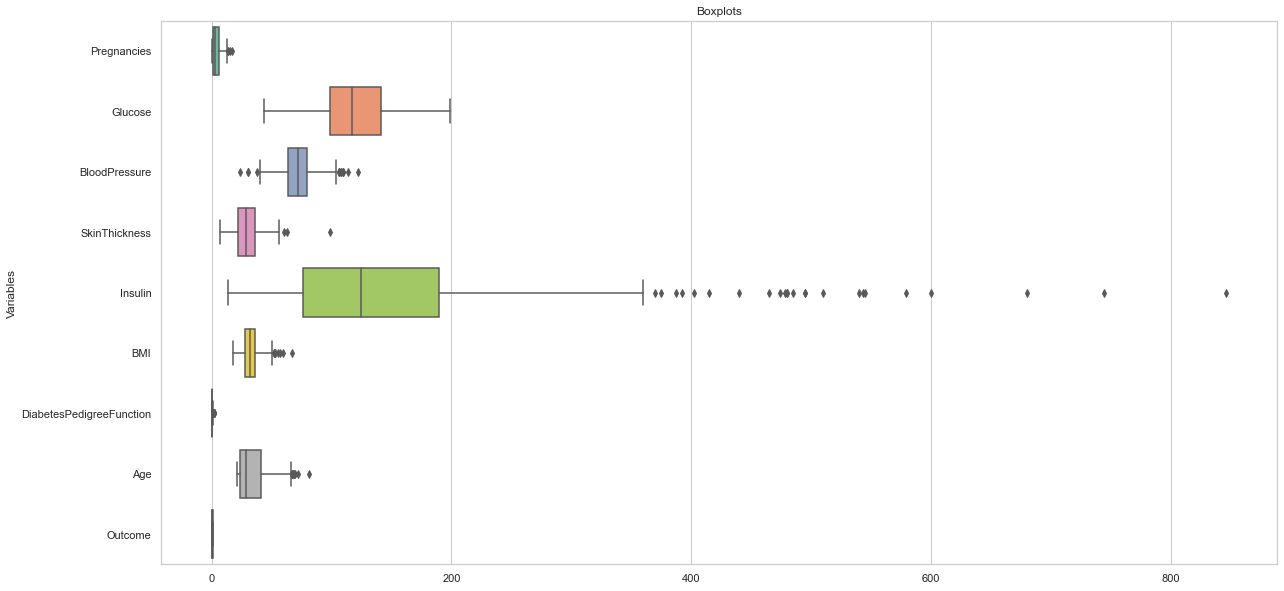

In [944]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

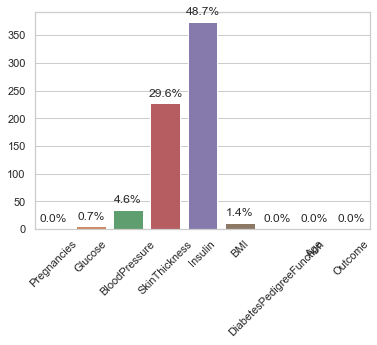

In [945]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [946]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [947]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [948]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.9
train_val_df = df[msk]
testData = df[~msk]

mskVal = np.random.rand(len(train_val_df)) < 0.9
trainData = train_val_df[mskVal]
validationData = train_val_df[~mskVal]


In [949]:
 def separate_data_and_labels(df):
        data = df.copy()
        y_values = data[data.columns[-1]].values.reshape(data.shape[0], 1)
        data = data.drop([data.columns[-1]], axis=1)
        return data, y_values

In [950]:
x_train_data, y_train_values = separate_data_and_labels(trainData)
x_val_data, y_val_values = separate_data_and_labels(validationData)
x_test_data, y_test_values = separate_data_and_labels(testData)

In [951]:
del(testData)
del(validationData)
del(trainData)
del(df)

In [952]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [953]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [985]:
class DiabetesPredictor:
    def __init__(self, name):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.name = name

    def fit(self, train_df, y_train, val_df, y_val, replaceOutliers=False, replaceNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1, earlyStop = False, dropOut = False):
        train_dataframe = train_df.copy()
        fit_df = train_dataframe.copy()

        self.columnsToRemove = columnsToRemove.copy()
        self.nullCols = nullColumns.copy()
        self.replaceNulls = replaceNulls
        self.replaceOutliers = replaceOutliers
        self.polyFeatDeg = polyFeatDeg
        self.binsDiscretizer = binsDiscretizer
        self.earlyStop = earlyStop
        self.dropOut = dropOut

        self.replace_values_nulls = []
        self.replace_values_outliers = []
        self.outliersLimits = []

        self.nullCols = [n for n in self.nullCols if n not in self.columnsToRemove]
        self.outlierCols = {}
        for k in outliersColumnsMap:
            if k not in self.columnsToRemove:
                self.outlierCols[k] = outliersColumnsMap[k].copy()

        if self.replaceNulls:
            fit_df[self.nullCols] = fit_df[self.nullCols].replace(0,np.NaN)
        ##Parametros##
        self.replace_values_outliers = self.__get_cols_median__(fit_df)
        self.outliersLimits = self.__get_outliers_limits__(fit_df)

        if(self.replaceOutliers):
            fit_df = self.__replace_outliers__(fit_df)

        ##Parametros##
        self.replace_values_nulls = self.__get_cols_median__(fit_df)
        
        if(self.replaceNulls):
            fit_df = self.__replace_nulls__(fit_df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            polyArray = poly.fit_transform(fit_df)
            c = poly.get_feature_names(fit_df.columns)
            fit_df = pd.DataFrame(polyArray, columns = c)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            fit_df = disc.fit_transform(fit_df)

        ##Parametros##
        self.mean_cols = self.__get_cols_mean__(fit_df)
        self.std_cols = self.__get_cols_std__(fit_df)

        train_dataframe = self.__preprocess_data__(train_dataframe)
        x_train_values = train_dataframe.values
        y_train_values = y_train.copy()

        self.input_shape = x_train_values.shape

        x_val_df = val_df.copy()
        x_val_df = self.__preprocess_data__(x_val_df)
        x_val_values = x_val_df.values
        y_val_values = y_val.copy()

        self.hypermodel = self.__tune_hyperparams__(x_train_values, y_train_values, x_val_values,y_val_values)

        return self.evaluate(x_val_df, y_val_values, testing = False)
        
    def __preprocess_data__(self, data):
        df = data.copy()
        df = self.__remove_columns__(df)

        if self.replaceNulls:
            df[self.nullCols] = df[self.nullCols].replace(0,np.NaN)

        if(self.replaceOutliers):
            df = self.__replace_outliers__(df)

        if(self.replaceNulls):
            df = self.__replace_nulls__(df)

        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            polyArray = poly.fit_transform(df)
            c = poly.get_feature_names(df.columns)
            df = pd.DataFrame(polyArray, columns = c)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            df = disc.fit_transform(df)

        df = self.__normalize_data__(df)

        return df

    def __get_cols_mean__(self, data):
        meandf = data.mean(axis = 0)
        meandf.columns = data.columns
        return meandf

    def __get_cols_std__(self, data):
        stddf= data.std(axis = 0)
        stddf.columns = data.columns
        return stddf

    def __get_cols_median__(self, data):
        mediandf = data.median(axis = 0)
        mediandf.columns = data.columns
        return mediandf

    def __get_outliers_limits__(self, data):
        df = pd.DataFrame(np.zeros((1,len(data.columns))), columns=data.columns)
        df = df.astype('object')
        for col in data.columns:
            col_min = 0
            col_max = np.Infinity
            if (col in self.outlierCols):
                #Cálculo de parámetros para obtener los outliers.
                q1 = data[col].quantile(0.25)
                q3 = data[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                lower_tail = q1 - 1.5 * iqr
                upper_tail = q3 + 1.5 * iqr

                col_min = min(lower_tail, self.outlierCols[col][0])
                col_max = max(upper_tail,self.outlierCols[col][1])
            lims = [col_min, col_max]
            df[col][0] = lims
        return df

    def __replace_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        df = dataframe.copy()
        for col in df.columns:
            out_min = self.outliersLimits[col][0][0]
            out_max = self.outliersLimits[col][0][1]
            for i in df[col]:
                if i > out_max or i < out_min:
                    df[col] = df[col].replace(i, self.replace_values_outliers[col])
        return df

    def __replace_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df[col]=df[col].replace(np.NaN, self.replace_values_nulls[col])
        return df

    def __normalize_data__(self, dataframe):
        # Mean, columnar axis.
        df = dataframe.copy()
        for col in df.columns:
            if (self.std_cols[col] != 0):
                df[col] = (df[col] - self.mean_cols[col]) / self.std_cols[col]
            else:
                df[col] = 0
        return df

    def __remove_columns__(self, dataframe):
        df = dataframe.copy()
        df = df.drop(self.columnsToRemove, axis=1)
        return df

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)

        if(self.dropOut):
            model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5),input_shape=(self.input_shape[1],)))
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
        else:
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.input_shape[1],)))
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        #hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate= hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
        )

        model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __tune_hyperparams__(self, x_train, y_train, x_val, y_val):
        # log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        # hist_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir,
        #     histogram_freq=1,
        #     embeddings_freq=1,
        #     write_graph=True,
        #     update_freq='batch')
        tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_auc", direction="max"),
                     max_epochs=20,
                     factor=3,
                     seed = 4,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        #### Search for HyperParams #####
        if (self.earlyStop):
            tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), callbacks=[stop_early], use_multiprocessing=True, verbose=2)
        else:
            tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), use_multiprocessing=True, verbose=2)

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]

        # Build the model with the optimal hyperparameters and train it on the data
        model = tuner.hypermodel.build(best_hps)
        if (self.earlyStop):
            history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val),callbacks=[stop_early], verbose=0)
        else:
            history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val), verbose=0)

        # Plot Loss
        plot_loss(history)

        # Find optimal Epocs
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

        # Build and Retrain the model with best Epochs
        hypermodel = tuner.hypermodel.build(best_hps)
        if (self.earlyStop):
            hypermodel.fit(x_train, y_train, epochs=best_epoch,callbacks=[stop_early], validation_data = (x_val, y_val), verbose=0)
        else:
            hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data = (x_val, y_val), verbose=0)

        # Return trained model
        return hypermodel

    def evaluate(self, x_val_df, y_val, testing=True):
        x_df = x_val_df.copy()
        predictions, rounded_preds = self.predict(x_df, testing=testing)

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        spe = specificity(y_val.astype(float),  rounded_preds.astype(float))
        sen = sensitivity(y_val.astype(float),  rounded_preds.astype(float))
        ppv = positive_predictive_value(y_val.astype(float), rounded_preds.astype(float))
        npv = negative_predictive_value(y_val.astype(float), rounded_preds.astype(float))

        self.plot_roc(fpr_keras, tpr_keras, auc_keras)

        print('AUC ' + str(auc_keras))
        print('Specificity: ' + str(spe))
        print('Sensitivity: ' + str(sen))
        print('Positive Predictive Value: ' + str(ppv))
        print('Negative Predictive Value: ' + str(npv))

        return auc_keras, spe, sen, ppv, npv

    def predict(self, x_val_df, testing=True):
        x_df = x_val_df.copy()
        if (testing):
            x_df = self.__preprocess_data__(x_df)
        predictions = self.hypermodel(x_df.values)
        rounded_preds = np.rint(predictions)
        return predictions, rounded_preds

    def plot_roc(self, fpr_keras, tpr_keras, auc_keras):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=' (Area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve ' + self.name)
        plt.legend(loc='best')
        plt.show()
        

In [955]:
predictor = DiabetesPredictor('predictor')

Trial 30 Complete [00h 00m 08s]
val_auc: 0.30142858624458313

Best val_auc So Far: 0.7371428410212199
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit


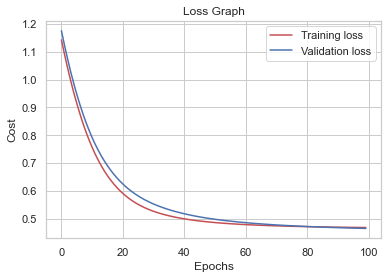

Epoch 1/100
19/19 [==============================] - 1s 20ms/step - loss: 1.1432 - auc: 0.3653 - val_loss: 1.1759 - val_auc: 0.3111
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0912 - auc: 0.3779 - val_loss: 1.1234 - val_auc: 0.3225
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0421 - auc: 0.3910 - val_loss: 1.0746 - val_auc: 0.3389
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9964 - auc: 0.4071 - val_loss: 1.0290 - val_auc: 0.3550
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9538 - auc: 0.4240 - val_loss: 0.9866 - val_auc: 0.3789
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9141 - auc: 0.4431 - val_loss: 0.9471 - val_auc: 0.3968
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8771 - auc: 0.4638 - val_loss: 0.9108 - val_auc: 0.4164
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8433 - 

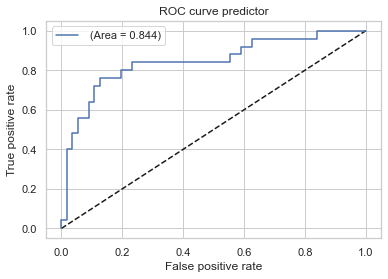

AUC 0.8442857142857142
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6785714261479592, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8867924511569953, shape=(), dtype=float64)


In [956]:
 aucPred, spePred, senPred, ppvPred, npvPred = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values)

## Limpiando Datos
#### Reemplazando Nulls por la mediana

Trial 30 Complete [00h 00m 08s]
val_auc: 0.2582142949104309

Best val_auc So Far: 0.7714285651842753
Total elapsed time: 00h 03m 02s
INFO:tensorflow:Oracle triggered exit


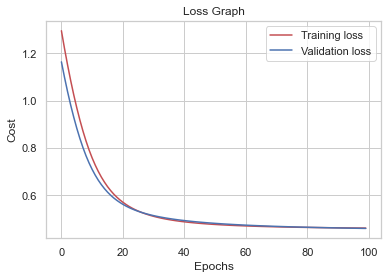

Epoch 1/100
19/19 [==============================] - 1s 21ms/step - loss: 1.2952 - auc: 0.3226 - val_loss: 1.1641 - val_auc: 0.2686
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.2209 - auc: 0.3336 - val_loss: 1.0986 - val_auc: 0.2846
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1507 - auc: 0.3461 - val_loss: 1.0378 - val_auc: 0.3057
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0853 - auc: 0.3595 - val_loss: 0.9811 - val_auc: 0.3229
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0243 - auc: 0.3763 - val_loss: 0.9299 - val_auc: 0.3486
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9689 - auc: 0.3977 - val_loss: 0.8829 - val_auc: 0.3746
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9177 - auc: 0.4176 - val_loss: 0.8403 - val_auc: 0.4046
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.8713 - 

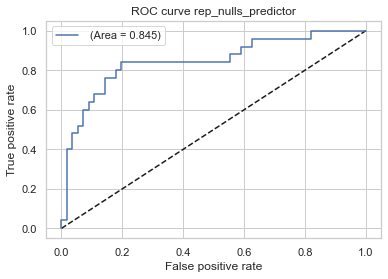

AUC 0.845
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [957]:
predictorRepNulls = DiabetesPredictor('rep_nulls_predictor')
aucRepNulls, speRepNulls, senRepNulls, ppvRepNulls, npvRepNulls = predictorRepNulls.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Reemplazando Outliers


Trial 30 Complete [00h 00m 08s]
val_auc: 0.26499998569488525

Best val_auc So Far: 0.7265475789705912
Total elapsed time: 00h 03m 38s
INFO:tensorflow:Oracle triggered exit


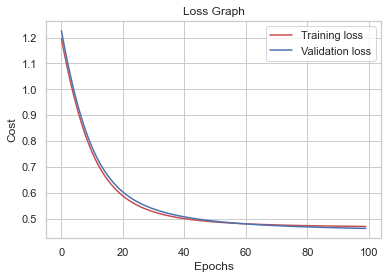

Epoch 1/100
19/19 [==============================] - 1s 20ms/step - loss: 1.1956 - auc: 0.3503 - val_loss: 1.2265 - val_auc: 0.2700
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1351 - auc: 0.3627 - val_loss: 1.1634 - val_auc: 0.2846
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0784 - auc: 0.3757 - val_loss: 1.1047 - val_auc: 0.3018
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0255 - auc: 0.3901 - val_loss: 1.0503 - val_auc: 0.3218
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9766 - auc: 0.4062 - val_loss: 0.9994 - val_auc: 0.3429
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.9309 - auc: 0.4252 - val_loss: 0.9526 - val_auc: 0.3611
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8891 - auc: 0.4438 - val_loss: 0.9100 - val_auc: 0.3836
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8508 - 

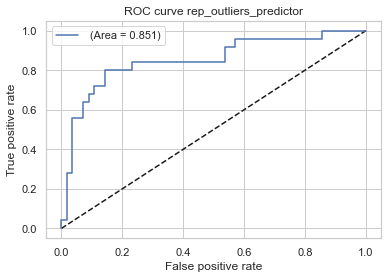

AUC 0.8514285714285715
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6896551700356718, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9038461521079881, shape=(), dtype=float64)


In [958]:
predictorRepOutliers = DiabetesPredictor('rep_outliers_predictor')
aucRepOut, speRepOut, senRepOut, ppvRepOut, npvRepOut = predictorRepOutliers.fit(x_train_data, y_train_values, x_val_data, y_val_values, replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})

#### Reemplazando Outliers y nulls


Trial 30 Complete [00h 00m 09s]
val_auc: 0.2574999928474426

Best val_auc So Far: 0.770357092221578
Total elapsed time: 00h 03m 26s
INFO:tensorflow:Oracle triggered exit


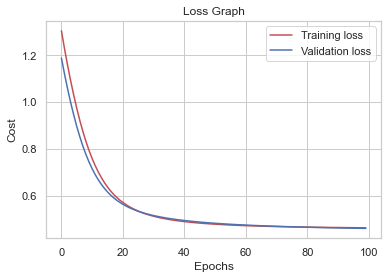

Epoch 1/100
19/19 [==============================] - 1s 25ms/step - loss: 1.3042 - auc: 0.3211 - val_loss: 1.1886 - val_auc: 0.2657
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.2290 - auc: 0.3319 - val_loss: 1.1211 - val_auc: 0.2804
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1582 - auc: 0.3446 - val_loss: 1.0578 - val_auc: 0.3043
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0920 - auc: 0.3578 - val_loss: 0.9992 - val_auc: 0.3200
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0303 - auc: 0.3742 - val_loss: 0.9457 - val_auc: 0.3446
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9739 - auc: 0.3945 - val_loss: 0.8964 - val_auc: 0.3707
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9218 - auc: 0.4156 - val_loss: 0.8522 - val_auc: 0.3986
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8749 - 

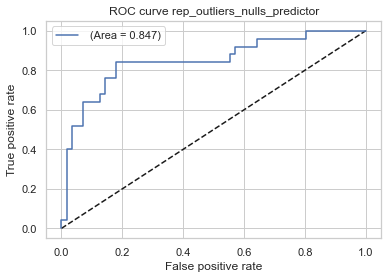

AUC 0.8471428571428571
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [959]:
predictorRepOutliersAndNulls = DiabetesPredictor('rep_outliers_nulls_predictor')
aucRepOutN, speRepOutN, senRepOutN, ppvRepOutN, npvRepOutN = predictorRepOutliersAndNulls.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})


#### Removiendo Columnas

Trial 30 Complete [00h 00m 11s]
val_auc: 0.20857142408688864

Best val_auc So Far: 0.5659524202346802
Total elapsed time: 00h 03m 42s
INFO:tensorflow:Oracle triggered exit


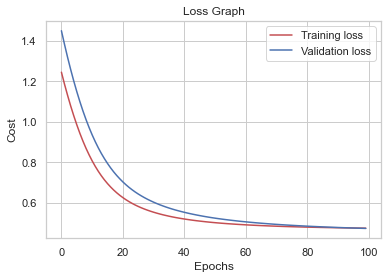

Epoch 1/100
19/19 [==============================] - 1s 19ms/step - loss: 1.2455 - auc: 0.3045 - val_loss: 1.4505 - val_auc: 0.2129
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1865 - auc: 0.3159 - val_loss: 1.3831 - val_auc: 0.2225
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1309 - auc: 0.3275 - val_loss: 1.3194 - val_auc: 0.2336
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0789 - auc: 0.3388 - val_loss: 1.2586 - val_auc: 0.2493
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0298 - auc: 0.3535 - val_loss: 1.2023 - val_auc: 0.2604
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9848 - auc: 0.3690 - val_loss: 1.1493 - val_auc: 0.2696
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9430 - auc: 0.3857 - val_loss: 1.0999 - val_auc: 0.2868
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9044 - 

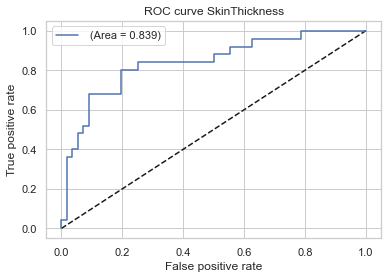

AUC 0.8392857142857142
Specificity: tf.Tensor(0.8035714271364796, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.71999999712, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6206896530321047, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8653846137204142, shape=(), dtype=float64)


In [961]:
bestAuc = aucRepOut
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(col)
	aucR, speR, senR, ppvR, npvR = pred.fit(x_train_data, y_train_values, x_val_data, y_val_values, replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=[col])
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



In [962]:
print(removeCols)
print(removeColsAuc)

['BloodPressure', 'Age']
[0.8571428571428572, 0.8521428571428571]


Trial 30 Complete [00h 00m 09s]
val_auc: 0.25214284658432007

Best val_auc So Far: 0.5339285929997762
Total elapsed time: 00h 03m 47s
INFO:tensorflow:Oracle triggered exit


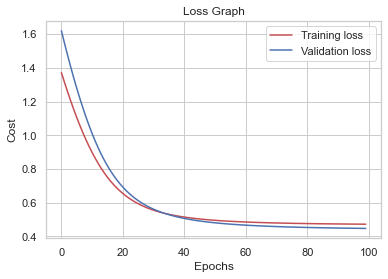

Epoch 1/100
19/19 [==============================] - 1s 18ms/step - loss: 1.3714 - auc: 0.3190 - val_loss: 1.6201 - val_auc: 0.2550
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.3137 - auc: 0.3253 - val_loss: 1.5461 - val_auc: 0.2614
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.2577 - auc: 0.3320 - val_loss: 1.4751 - val_auc: 0.2664
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 1.2044 - auc: 0.3386 - val_loss: 1.4067 - val_auc: 0.2686
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1534 - auc: 0.3463 - val_loss: 1.3409 - val_auc: 0.2729
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1045 - auc: 0.3548 - val_loss: 1.2779 - val_auc: 0.2818
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0580 - auc: 0.3649 - val_loss: 1.2182 - val_auc: 0.2936
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0142 - 

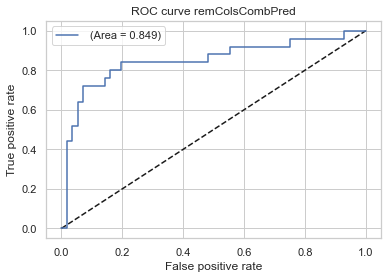

AUC 0.8485714285714286
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.71999999712, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6923076896449704, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8727272711404959, shape=(), dtype=float64)


In [963]:
remColsCombPred = DiabetesPredictor('remColsCombPred')
aucRCCP, speRCCP, senRCCP, ppvRCCP, npvRCCP = remColsCombPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=removeCols)

#### Sacando solo BloodPressure

Trial 30 Complete [00h 00m 09s]
val_auc: 0.2785714268684387

Best val_auc So Far: 0.5874999761581421
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


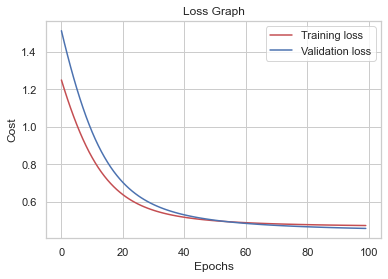

Epoch 1/100
19/19 [==============================] - 1s 17ms/step - loss: 1.2506 - auc: 0.3547 - val_loss: 1.5135 - val_auc: 0.2846
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1978 - auc: 0.3642 - val_loss: 1.4462 - val_auc: 0.2925
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1478 - auc: 0.3743 - val_loss: 1.3813 - val_auc: 0.3089
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0999 - auc: 0.3849 - val_loss: 1.3194 - val_auc: 0.3189
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0548 - auc: 0.3960 - val_loss: 1.2608 - val_auc: 0.3293
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0120 - auc: 0.4083 - val_loss: 1.2053 - val_auc: 0.3439
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9721 - auc: 0.4207 - val_loss: 1.1528 - val_auc: 0.3561
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.9346 - 

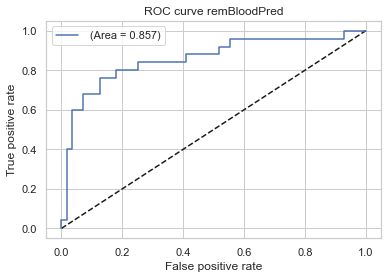

AUC 0.8571428571428572
Specificity: tf.Tensor(0.7857142843112245, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.624999998046875, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8979591818408996, shape=(), dtype=float64)


In [964]:
remBloodPred = DiabetesPredictor('remBloodPred')
aucRB, speRB, senRB, ppvRB, npvRB = remBloodPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"])


### Con PolynomialFeatures

       1  Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
0    1.0          1.0     85.0           66.0           29.0  26.6   
1    1.0          8.0    183.0           64.0            0.0  23.3   
2    1.0          1.0     89.0           66.0           23.0  28.1   
3    1.0          0.0    137.0           40.0           35.0  43.1   
4    1.0          5.0    116.0           74.0            0.0  25.6   
..   ...          ...      ...            ...            ...   ...   
596  1.0          2.0     88.0           58.0           26.0  28.4   
597  1.0          9.0    170.0           74.0           31.0  44.0   
598  1.0         10.0    101.0           76.0           48.0  32.9   
599  1.0          2.0    122.0           70.0           27.0  36.8   
600  1.0          1.0     93.0           70.0           31.0  30.4   

     DiabetesPedigreeFunction   Age  
0                       0.351  31.0  
1                       0.672  32.0  
2                       0.167  21.0  
3      

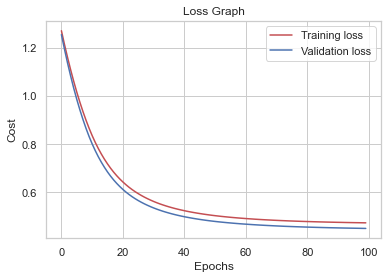

Epoch 1/100
19/19 [==============================] - 1s 18ms/step - loss: 1.2709 - auc: 0.2475 - val_loss: 1.2549 - val_auc: 0.2418
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.2139 - auc: 0.2547 - val_loss: 1.1940 - val_auc: 0.2486
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1597 - auc: 0.2630 - val_loss: 1.1366 - val_auc: 0.2575
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 1.1086 - auc: 0.2724 - val_loss: 1.0828 - val_auc: 0.2668
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0608 - auc: 0.2827 - val_loss: 1.0328 - val_auc: 0.2775
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 1.0162 - auc: 0.2949 - val_loss: 0.9863 - val_auc: 0.2943
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9746 - auc: 0.3069 - val_loss: 0.9428 - val_auc: 0.3139
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.9354 - 

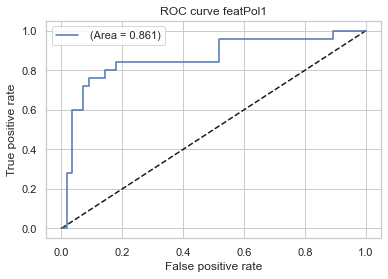

AUC 0.8607142857142857
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)
       1  Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
0    1.0          1.0     85.0           66.0           29.0  26.6   
1    1.0          8.0    183.0           64.0            0.0  23.3   
2    1.0          1.0     89.0           66.0           23.0  28.1   
3    1.0          0.0    137.0           40.0           35.0  43.1   
4    1.0          5.0    116.0           74.0            0.0  25.6   
..   ...          ...      ...            ...            ...   ...   
596  1.0          2.0     88.0           58.0           26.0  28.4   
597  1.0          9.0    170.0           74.0           31.0  44.0   
598  1.0         10.0    101.0           76.0       

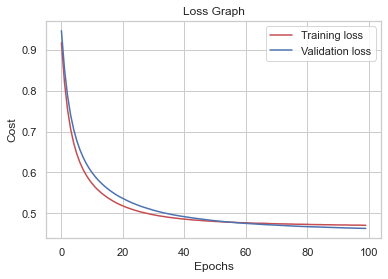

Epoch 1/100
19/19 [==============================] - 1s 25ms/step - loss: 0.9175 - auc: 0.4211 - val_loss: 0.9477 - val_auc: 0.4789
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.8208 - auc: 0.4915 - val_loss: 0.8529 - val_auc: 0.5700
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.7537 - auc: 0.5703 - val_loss: 0.7869 - val_auc: 0.6411
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.7057 - auc: 0.6392 - val_loss: 0.7388 - val_auc: 0.6768
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6711 - auc: 0.6915 - val_loss: 0.7043 - val_auc: 0.7229
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6452 - auc: 0.7266 - val_loss: 0.6770 - val_auc: 0.7550
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6246 - auc: 0.7497 - val_loss: 0.6553 - val_auc: 0.7696
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.6079 -

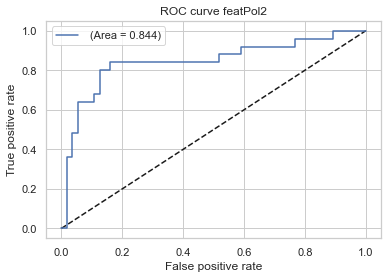

AUC 0.8442857142857143
Specificity: tf.Tensor(0.8749999984375, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7407407379972565, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9074074057270233, shape=(), dtype=float64)
       1  Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
0    1.0          1.0     85.0           66.0           29.0  26.6   
1    1.0          8.0    183.0           64.0            0.0  23.3   
2    1.0          1.0     89.0           66.0           23.0  28.1   
3    1.0          0.0    137.0           40.0           35.0  43.1   
4    1.0          5.0    116.0           74.0            0.0  25.6   
..   ...          ...      ...            ...            ...   ...   
596  1.0          2.0     88.0           58.0           26.0  28.4   
597  1.0          9.0    170.0           74.0           31.0  44.0   
598  1.0         10.0    101.0           76.0           

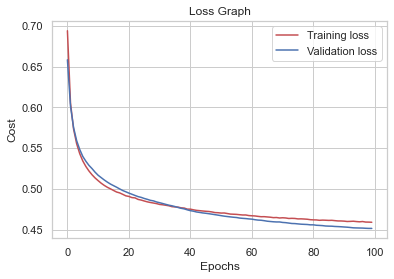

Epoch 1/100
19/19 [==============================] - 1s 20ms/step - loss: 0.6959 - auc: 0.6455 - val_loss: 0.6612 - val_auc: 0.7564
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6066 - auc: 0.7623 - val_loss: 0.6006 - val_auc: 0.8150
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5725 - auc: 0.8029 - val_loss: 0.5746 - val_auc: 0.8246
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5552 - auc: 0.8160 - val_loss: 0.5584 - val_auc: 0.8386
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.5432 - auc: 0.8214 - val_loss: 0.5481 - val_auc: 0.8407
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5346 - auc: 0.8271 - val_loss: 0.5401 - val_auc: 0.8439
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.5276 - auc: 0.8307 - val_loss: 0.5339 - val_auc: 0.8457
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5219 - 

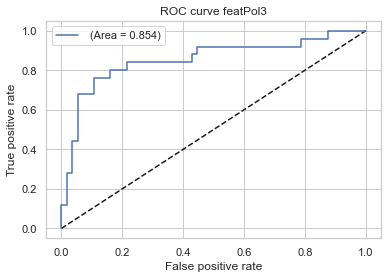

AUC 0.8535714285714285
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [967]:
aucPolys = []
for i in range(1,4):
    polyPred = DiabetesPredictor('featPol' + str(i))

    aucPoly, spePoly, senPoly, ppvPoly, npvPoly = polyPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = i)
    aucPolys.append(aucPoly)

bestPolDeg = aucPolys.index(max(aucPolys)) + 1


In [969]:
print('Best Degree: ' + str(bestPolDeg) + " --- AUC: " + str(max(aucPolys)))

Best Degree: 1 --- AUC: 0.8607142857142857


#### Con EarlyStopping

Trial 30 Complete [00h 00m 08s]
val_auc: 0.23607143759727478

Best val_auc So Far: 0.6986904939015707
Total elapsed time: 00h 03m 32s
INFO:tensorflow:Oracle triggered exit


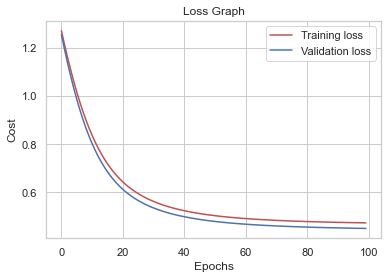

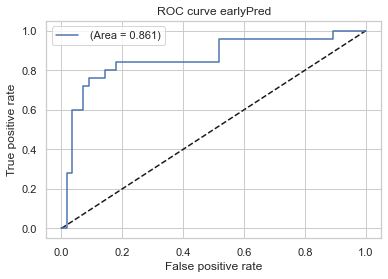

AUC 0.8607142857142857
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [983]:
earlyPred = DiabetesPredictor('earlyPred')
aucEarly, speEarly, senEarly, ppvEarly, npvEarly = earlyPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True)

#### Con DropOut

Trial 30 Complete [00h 00m 08s]
val_auc: 0.2353571653366089

Best val_auc So Far: 0.5194047689437866
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


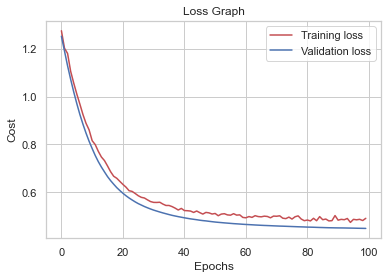

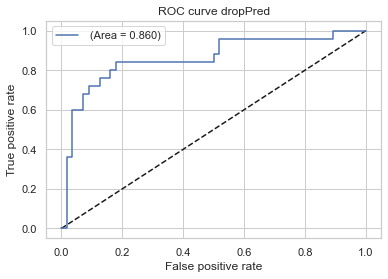

AUC 0.8599999999999999
Specificity: tf.Tensor(0.8749999984375, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7307692279585799, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8909090892892562, shape=(), dtype=float64)


In [986]:
dropPred = DiabetesPredictor('dropPred')
aucDrop, speDrop, senDrop, ppvDrop, npvDrop = dropPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True, dropOut = True)